the goal of this notebook is to obtain a plot that looks like this:
- x-axis has 5 values: one for each tile in the y-axis (this represents distance to target).
- the y-axis has `number of keypoints` values.
- the (x, y) value will be a heatmap with the importance of each keypoint to predict the value in that specific tile.

another variation is not to discretize the x-axis into tiles, but then it's tricky to average over trials.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import yaml

import motorlab as ml

In [ ]:
os.chdir(Path().resolve().parent)

In [ ]:
# regression, fc, with homing
run = 20250710162620  # removed: none
run = 20250710230142  # removed: head
run = 20250710232432  # removed: limbs
run = 20250710234620  # removed: limbs + head

In [ ]:
run = 20250711173716  # projected to pc

In [ ]:
config_path = f"config/poses_to_position/{run}.yaml"
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

In [ ]:
model = ml.model.create_model(
    config,
    is_train=False,
)

In [ ]:
_, train_intervals, _ = ml.utils.get_tiers_intervals(
    config["DATA_DIR"],
    config["sessions"],
    config["experiment"],
    include_trial=config["intervals"]["include_trial"],
    include_homing=config["intervals"]["include_homing"],
    include_sitting=config["intervals"]["include_sitting"],
    shuffle=False,
    seed=0,
)
intervals = ml.utils.get_intervals(
    config["DATA_DIR"],
    config["sessions"],
    config["experiment"],
    include_trial=config["intervals"]["include_trial"],
    include_homing=config["intervals"]["include_homing"],
    include_sitting=config["intervals"]["include_sitting"],
    shuffle=False,
    seed=0,
)
data_dict = ml.data.load_all(config, train_intervals)

the importance is computed as follows: for each session i have several trials. i'll feed each frame of each trial to the model and compute the gradient of the output ((x, y) coordinates of the center of mass) with respect to the input (keypoints in egocentric coordinates). this tells me which keypoints matter and which doesn't for the prediction. by doing this i can obtain a dictionary with sessions as keys and values will be a list of trials. then, for each trial, i have a numpy array with shape `(trial length, 2, number of keypoints)`. basically, each frame contains a jacobian and we have 2 rows because we're predicting the (x, y) coordinates of the center of mass, even though we're mainly interested in the y-coordinate for now.

In [ ]:
grads = {session: [] for session in intervals}

for session in intervals:
    d = data_dict[session]["poses"]
    for s, e in intervals[session]:
        x = torch.tensor(d[s:e], device=ml.utils.device, requires_grad=True)
        pred = model(x, session)

        grad = torch.stack(
            [
                torch.autograd.grad(
                    outputs=pred[:, i],
                    inputs=x,
                    grad_outputs=torch.ones_like(pred[:, i]),
                    retain_graph=True,
                )[0]
                for i in range(pred.shape[-1])
            ],
            dim=1,
        )
        grads[session].append(grad.detach().cpu().numpy())

now that we have gradients per session, per trial, we can bin the trials into tiles. in order to do this, we iterate over both the gradients and poses at the same time, get the tile the monkey is in each frame using the poses, and put the gradient into that bin. i'll do this for each trial and basically concatenate the gradients per bin. meaning: at the end i have a dictionary with sessions as keys and another dictionary as values. the inner dictionary has each tile as a key and values will be a list of gradients where each element of the list represents a gradient of a given time point in which the monkey was in that specific tile.

In [ ]:
poses = dict()
for session in config["sessions"]:
    POSES_DIR = Path(config["DATA_DIR"]) / session / "poses"
    poses[session] = ml.data.load_from_memmap(POSES_DIR)

In [ ]:
grads_per_tile = {
    session: {i: [] for i in range(15)} for session in config["sessions"]
}

for session in config["sessions"]:
    for t, (s, e) in enumerate(intervals[session]):
        tiles = ml.room.get_tiles(
            poses[session][s:e, 0], poses[session][s:e, 1]
        ).astype(int)
        for i, tile in enumerate(tiles):
            grads_per_tile[session][tile].append(grads[session][t][i])

In [ ]:
importance_per_tile = {
    session: {
        i: np.stack(
            [np.abs(g) for g in grads_per_tile[session][i]], axis=0
        ).mean(axis=0)
        # .reshape(2, 21, 3)
        # .sum(axis=-1)
        for i in range(15)
        if grads_per_tile[session][i]
    }
    for session in config["sessions"]
}

In [ ]:
importance_y_axis = {
    session: {i: None for i in range(5)} for session in config["sessions"]
}

for session in config["sessions"]:
    for i in range(0, 15, 3):
        importance_y_axis[session][i // 3] = np.mean(
            [
                importance_per_tile[session][t][1]
                for t in range(i, i + 3)
                if t in importance_per_tile[session]
            ],
            axis=0,
        )

for keypoints

In [ ]:
results_y_axis = {
    "session": [],
    "tile": [],
    "keypoint": [],
    "importance": [],
}

for session in importance_y_axis:
    for tile in importance_y_axis[session]:
        for kp, idx in ml.poses.keypoints_dict["gbyk"].items():
            results_y_axis["session"].append(session)
            results_y_axis["tile"].append(tile)
            results_y_axis["keypoint"].append(kp)
            results_y_axis["importance"].append(
                importance_y_axis[session][tile][idx]
            )

df_results_y_axis = pd.DataFrame(results_y_axis)

In [ ]:
nrows = len(config["sessions"]) // 2
ncols = 2 if len(config["sessions"]) > 2 else len(config["sessions"])

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 5 * nrows),
    sharex=True,
    sharey=True,
)

for i, session in enumerate(config["sessions"]):
    sub_df = df_results_y_axis[df_results_y_axis["session"] == session]
    pivot = sub_df.pivot(index="keypoint", columns="tile", values="importance")
    sns.heatmap(pivot, ax=axes[i // ncols, i % ncols])
    axes[i // ncols, i % ncols].set_title(session)

plt.tight_layout()
plt.show()

for pcas

In [ ]:
results_y_axis = {
    "session": [],
    "tile": [],
    "pc": [],
    "importance": [],
}

for session in importance_y_axis:
    for tile in importance_y_axis[session]:
        for idx in range(63):
            results_y_axis["session"].append(session)
            results_y_axis["tile"].append(tile)
            results_y_axis["pc"].append(idx)
            results_y_axis["importance"].append(
                importance_y_axis[session][tile][idx]
            )

df_results_y_axis = pd.DataFrame(results_y_axis)

In [ ]:
nrows = len(config["sessions"]) // 2
ncols = 2 if len(config["sessions"]) > 2 else len(config["sessions"])

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 5 * nrows),
    sharex=True,
    sharey=True,
)

for i, session in enumerate(config["sessions"]):
    sub_df = df_results_y_axis[df_results_y_axis["session"] == session]
    pivot = sub_df.pivot(index="pc", columns="tile", values="importance")
    sns.heatmap(pivot, ax=axes[i // ncols, i % ncols])
    axes[i // ncols, i % ncols].set_title(session)

plt.tight_layout()
plt.show()

In [ ]:
importance_x_axis = {
    session: {i: None for i in range(3)} for session in config["sessions"]
}

for session in config["sessions"]:
    for i in range(0, 3):
        importance_x_axis[session][i] = np.mean(
            [
                importance_per_tile[session][t][1]
                for t in range(i, 15, 3)
                if t in importance_per_tile[session]
            ],
            axis=0,
        )

In [ ]:
results_x_axis = {
    "session": [],
    "tile": [],
    "keypoint": [],
    "importance": [],
}

for session in importance_x_axis:
    for tile in importance_x_axis[session]:
        for kp, idx in ml.poses.keypoints_dict["gbyk"].items():
            results_x_axis["session"].append(session)
            results_x_axis["tile"].append(tile)
            results_x_axis["keypoint"].append(kp)
            results_x_axis["importance"].append(
                importance_x_axis[session][tile][idx]
            )

df_results_x_axis = pd.DataFrame(results_x_axis)

In [ ]:
nrows = len(config["sessions"]) // 2
ncols = 2 if len(config["sessions"]) > 2 else len(config["sessions"])

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 5 * nrows),
    sharex=True,
    sharey=True,
)

for i, session in enumerate(config["sessions"]):
    sub_df = df_results_x_axis[df_results_x_axis["session"] == session]
    pivot = sub_df.pivot(index="keypoint", columns="tile", values="importance")
    sns.heatmap(pivot, ax=axes[i // ncols, i % ncols])
    axes[i // ncols, i % ncols].set_title(session)

plt.tight_layout()
plt.show()

In [151]:
importance_bex_y_axis = {
    t: np.mean(
        [
            importance_y_axis[session][t]
            for session in config["sessions"]
            if "bex" in session
        ],
        axis=0,
    )
    for t in range(5)
}

In [ ]:
results_bex_y_axis = {
    "tile": [],
    "keypoint": [],
    "importance": [],
}


for tile in importance_bex_y_axis:
    for kp, idx in ml.poses.keypoints_dict["gbyk"].items():
        results_bex_y_axis["tile"].append(tile)
        results_bex_y_axis["keypoint"].append(kp)
        results_bex_y_axis["importance"].append(
            importance_bex_y_axis[tile][idx]
        )

df_results_bex_y_axis = pd.DataFrame(results_bex_y_axis)

In [ ]:
pivot = df_results_bex_y_axis.pivot(
    index="keypoint", columns="tile", values="importance"
)
g = sns.heatmap(pivot)
g.set_title("bex")
plt.show()

In [152]:
results_bex_y_axis = {
    "tile": [],
    "pc": [],
    "importance": [],
}


for tile in importance_bex_y_axis:
    for idx in range(63):
        results_bex_y_axis["tile"].append(tile)
        results_bex_y_axis["pc"].append(idx)
        results_bex_y_axis["importance"].append(
            importance_bex_y_axis[tile][idx]
        )

df_results_bex_y_axis = pd.DataFrame(results_bex_y_axis)

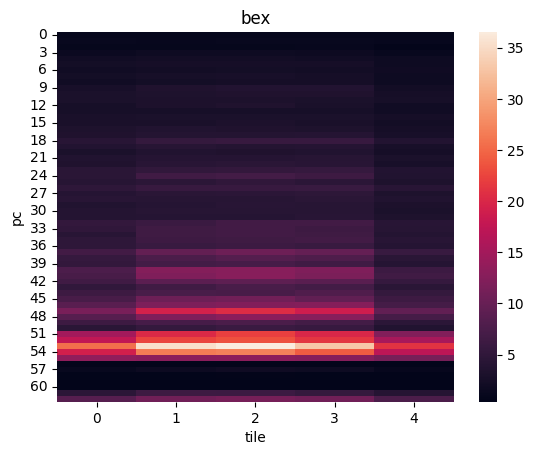

In [153]:
pivot = df_results_bex_y_axis.pivot(
    index="pc", columns="tile", values="importance"
)
g = sns.heatmap(pivot)
g.set_title("bex")
plt.show()

In [156]:
importance_ken_y_axis = {
    t: np.mean(
        [
            importance_y_axis[session][t]
            for session in config["sessions"]
            if "ken" in session
        ],
        axis=0,
    )
    for t in range(5)
}

In [ ]:
results_ken_y_axis = {
    "tile": [],
    "keypoint": [],
    "importance": [],
}


for tile in importance_ken_y_axis:
    for kp, idx in ml.poses.keypoints_dict["gbyk"].items():
        results_ken_y_axis["tile"].append(tile)
        results_ken_y_axis["keypoint"].append(kp)
        results_ken_y_axis["importance"].append(
            importance_ken_y_axis[tile][idx]
        )

df_results_ken_y_axis = pd.DataFrame(results_ken_y_axis)

In [ ]:
pivot = df_results_ken_y_axis.pivot(
    index="keypoint", columns="tile", values="importance"
)
g = sns.heatmap(pivot)
g.set_title("ken")
plt.show()

In [157]:
results_ken_y_axis = {
    "tile": [],
    "pc": [],
    "importance": [],
}


for tile in importance_ken_y_axis:
    for idx in range(63):
        results_ken_y_axis["tile"].append(tile)
        results_ken_y_axis["pc"].append(idx)
        results_ken_y_axis["importance"].append(
            importance_ken_y_axis[tile][idx]
        )

df_results_ken_y_axis = pd.DataFrame(results_ken_y_axis)

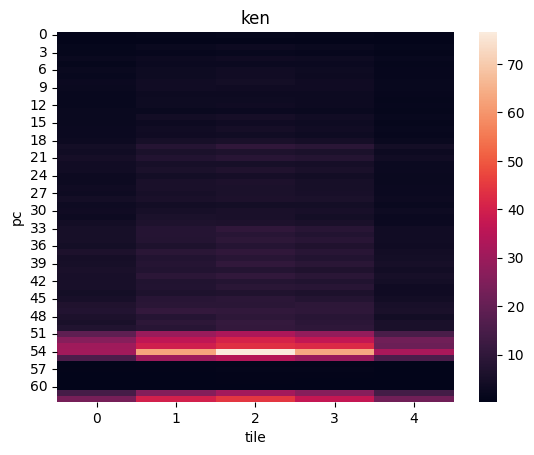

In [158]:
pivot = df_results_ken_y_axis.pivot(
    index="pc", columns="tile", values="importance"
)
g = sns.heatmap(pivot)
g.set_title("ken")
plt.show()